In [2]:
import torch
import torch_geometric
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from scipy.stats import ortho_group, special_ortho_group
from collections import Counter

# Two grids as two connected components
That way we have the same filters for the two graphs

In [54]:
grid_size = 8
n = grid_size * grid_size
num_data = 1000
num_train = 800
num_test = 200

grid = nx.grid_2d_graph(grid_size, grid_size)
grid = nx.convert_node_labels_to_integers(grid)
grid = grid.to_undirected()

grid2 = grid.copy()
two_grids = nx.disjoint_union(grid, grid2)

pos = dict()
for i in range(2):
    for j in range(grid_size):
        for k in range(grid_size):
            pos[i * n + j * grid_size + k] = (k, -j - i * grid_size)

# create the dataset
data_list = []
for i in range(num_data):
    freq = np.random.randint(1, grid_size // 2)
    sin = np.random.randint(0, 2)
    
    if sin == 1:
        x = np.sin(np.arange(grid_size) * freq * 2 * np.pi / grid_size)
    else:
        x = np.cos(np.arange(grid_size) * freq * 2 * np.pi / grid_size)

    label = np.random.randint(0, 2)
    if label == 0:
        flip = np.random.randint(0, 2)
        x1 = np.repeat(x.reshape(1,-1), grid_size, axis=0)
        x2 = x1.T
        if flip == 1:
            x1, x2 = x2, x1
        x = np.stack((x1, x2), axis=2)
    else:
        flip = np.random.randint(0, 2)
        x1 = np.repeat(x.reshape(1,-1), grid_size, axis=0)
        x2 = x1
        if flip == 1:
            x1 = x1.T
            x2 = x2.T
        x = np.stack((x1, x2), axis=2)

    edges = list(grid.edges)
    edges.extend([(v, u) for (u, v) in edges])
    edge_index = torch.tensor(edges).t().contiguous()

    # x is two channels, one for each graph
    x = x.transpose(2, 0, 1).reshape(-1)
    x = torch.tensor(x, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
    data.validate(raise_on_error=True)
    data_list.append(data)

# split the dataset into train and test
train_dataset = data_list[:num_train]
test_dataset = data_list[num_train:]


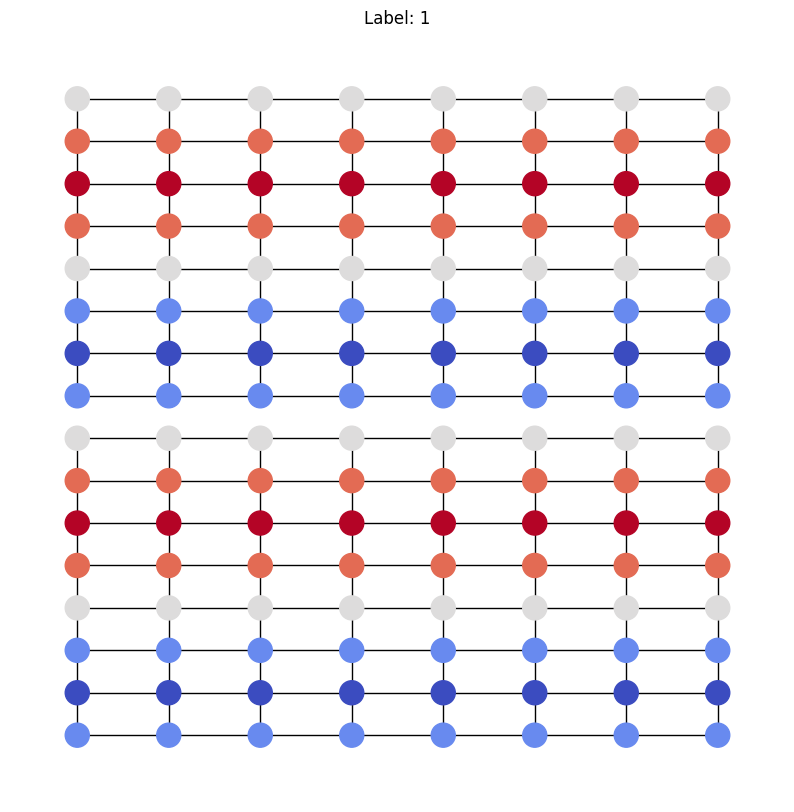

In [63]:
def plot_sample(grid, pos, data_sample):
    x = data_sample.x
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Label: {}'.format(data_sample.y.item()))
    nx.draw(grid, pos=pos, node_color=x, cmap='coolwarm', ax=ax)
    # set plot size
    # plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

sample_num = np.random.randint(0, num_train)
data_sample = data_list[sample_num]
plot_sample(two_grids, pos, data_sample)

# Same grid, two channels
Isotropic model perhaps succeeds since it has different filters for each channel

In [ ]:
# create a dataset of 2d pure harmonic functions on a 2d grid
# first we try a fixed grid size and vary the frequency
# a data element is two grid graphs, each could be a horizontal harmonic or a vertical harmonic
# the label of the data element is whether the two graphs are both horizontal or both vertical (1) or not (0)

grid_size = 10
num_data = 1000
num_train = 800
num_test = 200

pos = dict()
for i in range(grid_size):
    for j in range(grid_size):
        pos[i * grid_size + j] = (j, -i)

grid = nx.grid_2d_graph(grid_size, grid_size)
grid = nx.convert_node_labels_to_integers(grid)
grid = grid.to_undirected()

# create the dataset
data_list = []
for i in range(num_data):
    freq = np.random.randint(1, grid_size // 2)
    sin = np.random.randint(0, 2)
    
    if sin == 1:
        x = np.sin(np.arange(grid_size) * freq * 2 * np.pi / grid_size)
    else:
        x = np.cos(np.arange(grid_size) * freq * 2 * np.pi / grid_size)

    label = np.random.randint(0, 2)
    if label == 0:
        flip = np.random.randint(0, 2)
        x1 = np.repeat(x.reshape(1,-1), grid_size, axis=0)
        x2 = x1.T
        if flip == 1:
            x1, x2 = x2, x1
    else:
        flip = np.random.randint(0, 2)
        x1 = np.repeat(x.reshape(1,-1), grid_size, axis=0)
        x2 = x1
        if flip == 1:
            x1 = x1.T
            x2 = x2.T

    edges = list(grid.edges)
    edges.extend([(v, u) for (u, v) in edges])

    edge_index = torch.tensor(edges).t().contiguous()

    # x is two channels, one for each graph
    x = torch.tensor(np.stack([x1, x2], axis=2), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
    data_list.append(data)

# split the dataset into train and test
train_dataset = data_list[:num_train]
test_dataset = data_list[num_train:]

In [ ]:
def plot_sample(grid, pos, data_sample):
    x1 = data_sample.x[:,:,0]
    x2 = data_sample.x[:,:,1]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Label: {}'.format(data_sample.y.item()))

    nx.draw(grid, pos=pos, node_color=x1, cmap='coolwarm', ax=ax[0])
    ax[0].set_title('Horizontal')
    nx.draw(grid, pos=pos, node_color=x2, cmap='coolwarm', ax=ax[1])
    ax[1].set_title('Vertical')
    plt.show()

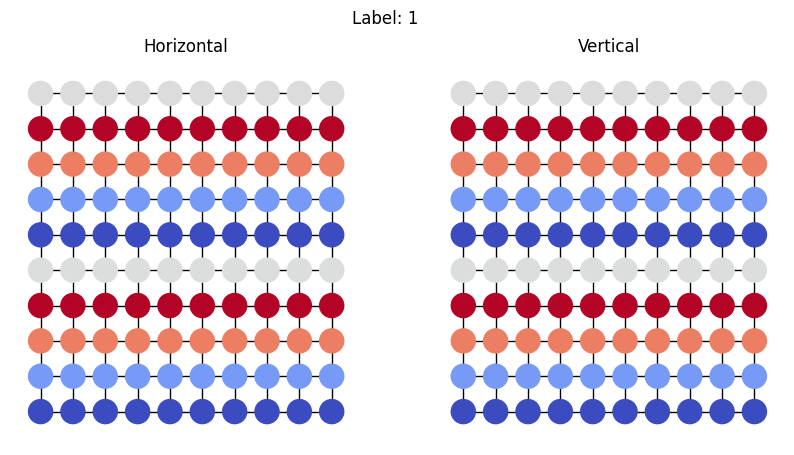

In [ ]:
sample_num = np.random.randint(0, num_train)
data_sample = data_list[sample_num]
plot_sample(grid, pos, data_sample)

In [ ]:
# use chebnet to classify the data
from torch_geometric.nn import ChebConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ChebConv(2, 32, 3)
        self.conv2 = ChebConv(32, 64, 3)
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool1d(x, kernel_size=x.shape[1])
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)

        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(epoch):
    model.train()
    loss_all = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        print(output.shape)
        print(data.y.shape)
        loss = torch.nn.functional.cross_entropy(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

def test():
    model.eval()
    correct = 0
    for data in test_dataset:
        data = data.to(device)
        output = model(data)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_dataset)

for epoch in range(1, 201):
    train_loss = train(epoch)
    test_acc = test()
    print('Epoch: {:03d}, Train Loss: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss, test_acc))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
